# 02. Neural Network Classification with PyTorch (Excursus)
In chapter 02 of the PyTorch course we trained a small neural network to classify a circular binary toy dataset (see `02_nn_classification.ipynb`). 
After 
training a two layer 
neural network
 with ReLU (for non-linearity) I became curious in how changing the hyperparameters would impact the performance and decision boundary of the model.
 
This notebook summarizes my experimentation. Here is what I did:
- increasing network depth
- alternating the size of the hidden layers (encoding-decoding)
- investigating causes and solutions to degrading performance of a five-layer neural network
- detecting vanishing gradients
- fixing vanishing gradients by decreasing the learning rate (five-layer neural network

In [41]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import plot_decision_boundary, get_data_loaders, fit, accuracy_fn, batch_loss
torch.__version__

'2.3.1'

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Recreating learning setup from chapter

### 1.1 Recreate dataset

In [6]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
# Make 1000 samples
n = 1000

X, y = make_circles(n, noise=0.03, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds = TensorDataset(X_train.to(device), y_train.to(device))
test_ds = TensorDataset(X_test.to(device), y_test.to(device))

train_dl, test_dl = get_data_loaders(train_ds, test_ds, batch_size=32)

### 1.2. Recreate loss function

In [7]:
loss_fn = nn.BCEWithLogitsLoss()

### 1.3 Recreate two layer ReLU model

In [23]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_relu = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
).to(device)

optim_relu = torch.optim.SGD(params=model_relu.parameters(), lr=0.1)


In [24]:
fit(epochs=500, 
    model=model_relu, 
    loss_fn=loss_fn, 
    opt=optim_relu, 
    train_dl=train_dl, 
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.69702, accuracy 43.00
Epoch 10: test loss 0.68857, accuracy 62.50
Epoch 20: test loss 0.68113, accuracy 61.50
Epoch 30: test loss 0.67294, accuracy 62.50
Epoch 40: test loss 0.66439, accuracy 63.50
Epoch 50: test loss 0.65204, accuracy 69.50
Epoch 60: test loss 0.62461, accuracy 78.50
Epoch 70: test loss 0.58025, accuracy 92.00
Epoch 80: test loss 0.52557, accuracy 92.50
Epoch 90: test loss 0.46248, accuracy 95.50
Epoch 100: test loss 0.39814, accuracy 95.50
Epoch 110: test loss 0.33874, accuracy 94.50
Epoch 120: test loss 0.28910, accuracy 95.00
Epoch 130: test loss 0.24951, accuracy 95.50
Epoch 140: test loss 0.21914, accuracy 95.00
Epoch 150: test loss 0.19570, accuracy 95.00
Epoch 160: test loss 0.17767, accuracy 96.00
Epoch 170: test loss 0.16358, accuracy 96.00
Epoch 180: test loss 0.15231, accuracy 96.00
Epoch 190: test loss 0.14328, accuracy 96.00
Epoch 200: test loss 0.13568, accuracy 96.00
Epoch 210: test loss 0.12956, accuracy 96.00
Epoch 220: test loss 

## 2. More layers
Let's investigate what happens when we add more layers to both of the networks.

### 2.1. Three layers

In [26]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_relu_3l = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
).to(device)

optim_relu_3l = torch.optim.SGD(params=model_relu_3l.parameters(), lr=0.1)

In [27]:
fit(epochs=500,
    model=model_relu_3l,
    loss_fn=loss_fn,
    opt=optim_relu_3l,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.69402, accuracy 50.00
Epoch 10: test loss 0.68873, accuracy 56.50
Epoch 20: test loss 0.67846, accuracy 64.50
Epoch 30: test loss 0.65890, accuracy 61.50
Epoch 40: test loss 0.60978, accuracy 73.50
Epoch 50: test loss 0.46259, accuracy 83.50
Epoch 60: test loss 0.36461, accuracy 85.00
Epoch 70: test loss 0.22728, accuracy 93.00
Epoch 80: test loss 0.19499, accuracy 95.00
Epoch 90: test loss 0.17222, accuracy 96.00
Epoch 100: test loss 0.15673, accuracy 95.50
Epoch 110: test loss 0.30208, accuracy 87.00
Epoch 120: test loss 0.18277, accuracy 92.50
Epoch 130: test loss 0.20653, accuracy 91.00
Epoch 140: test loss 0.17441, accuracy 93.50
Epoch 150: test loss 0.13016, accuracy 95.50
Epoch 160: test loss 0.12730, accuracy 96.00
Epoch 170: test loss 0.11573, accuracy 97.00
Epoch 180: test loss 0.11545, accuracy 97.00
Epoch 190: test loss 0.11308, accuracy 97.00
Epoch 200: test loss 0.11268, accuracy 97.00
Epoch 210: test loss 0.11264, accuracy 97.00
Epoch 220: test loss 

Let's compare the decision boundaries of the ReLU model with two and with three layers!

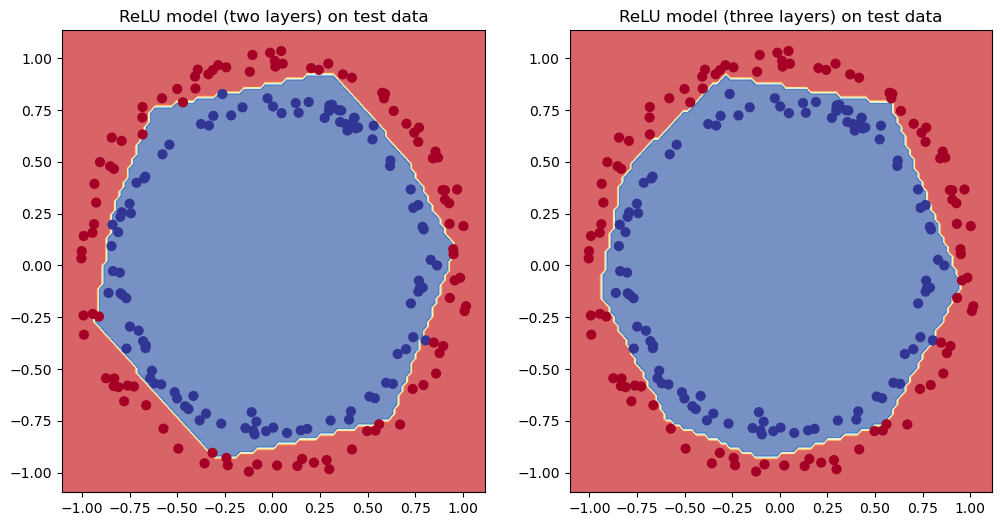

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("ReLU model (two layers) on test data")
plot_decision_boundary(model_relu, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("ReLU model (three layers) on test data")
plot_decision_boundary(model_relu_3l, X_test, y_test)

Adding another layer to the ReLU model results in a smoother and rounder decision boundary. Let's see if adding another layer increases performance.

### 2.2. Four layers

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_relu_4l = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
).to(device)

optim_relu_4l = torch.optim.SGD(params=model_relu_4l.parameters(), lr=0.1)

In [32]:
fit(epochs=600,
    model=model_relu_4l,
    loss_fn=loss_fn,
    opt=optim_relu_4l,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.69471, accuracy 50.00
Epoch 10: test loss 0.69344, accuracy 50.00
Epoch 20: test loss 0.69301, accuracy 50.00
Epoch 30: test loss 0.69255, accuracy 50.00
Epoch 40: test loss 0.69186, accuracy 50.00
Epoch 50: test loss 0.69074, accuracy 56.50
Epoch 60: test loss 0.68833, accuracy 64.00
Epoch 70: test loss 0.68257, accuracy 65.00
Epoch 80: test loss 0.67038, accuracy 64.50
Epoch 90: test loss 0.64049, accuracy 66.00
Epoch 100: test loss 0.51695, accuracy 74.50
Epoch 110: test loss 0.46473, accuracy 74.50
Epoch 120: test loss 0.31720, accuracy 85.00
Epoch 130: test loss 0.20404, accuracy 91.50
Epoch 140: test loss 0.17993, accuracy 92.00
Epoch 150: test loss 0.16702, accuracy 93.00
Epoch 160: test loss 0.17144, accuracy 93.50
Epoch 170: test loss 0.15903, accuracy 93.50
Epoch 180: test loss 0.14285, accuracy 93.50
Epoch 190: test loss 0.14309, accuracy 93.50
Epoch 200: test loss 0.13281, accuracy 94.00
Epoch 210: test loss 0.12523, accuracy 93.50
Epoch 220: test loss 

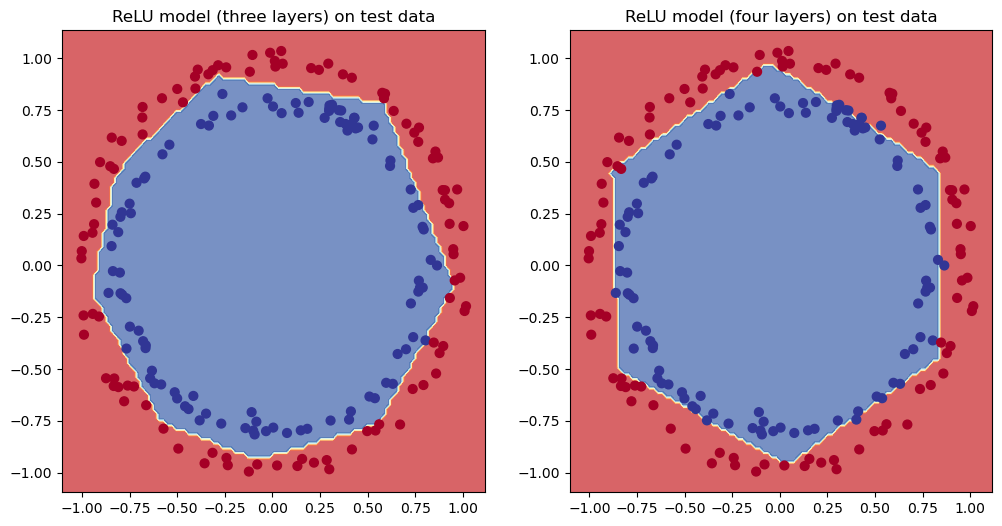

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("ReLU model (three layers) on test data")
plot_decision_boundary(model_relu_3l, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("ReLU model (four layers) on test data")
plot_decision_boundary(model_relu_4l, X_test, y_test)


Hmmm, performance does not really increase. Instead, a network with four layers seems to do no better than a network with two layers. Let's try five.

### 2.3. Five layers

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_relu_5l = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
).to(device)

optim_relu_5l = torch.optim.SGD(params=model_relu_5l.parameters(), lr=0.1)

In [35]:
fit(epochs=600,
    model=model_relu_5l,
    loss_fn=loss_fn,
    opt=optim_relu_5l,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.69745, accuracy 50.00
Epoch 10: test loss 0.69284, accuracy 50.00
Epoch 20: test loss 0.69264, accuracy 54.50
Epoch 30: test loss 0.69221, accuracy 53.50
Epoch 40: test loss 0.69124, accuracy 51.50
Epoch 50: test loss 0.68957, accuracy 51.50
Epoch 60: test loss 0.68020, accuracy 61.00
Epoch 70: test loss 0.62976, accuracy 66.00
Epoch 80: test loss 0.57772, accuracy 70.50
Epoch 90: test loss 0.69398, accuracy 51.00
Epoch 100: test loss 0.69218, accuracy 50.00
Epoch 110: test loss 0.69090, accuracy 58.50
Epoch 120: test loss 0.68825, accuracy 63.50
Epoch 130: test loss 0.66889, accuracy 63.50
Epoch 140: test loss 0.66338, accuracy 60.50
Epoch 150: test loss 0.69318, accuracy 50.00
Epoch 160: test loss 0.69317, accuracy 50.00
Epoch 170: test loss 0.69317, accuracy 50.00
Epoch 180: test loss 0.69317, accuracy 50.00
Epoch 190: test loss 0.69317, accuracy 50.00
Epoch 200: test loss 0.69317, accuracy 50.00
Epoch 210: test loss 0.69317, accuracy 50.00
Epoch 220: test loss 

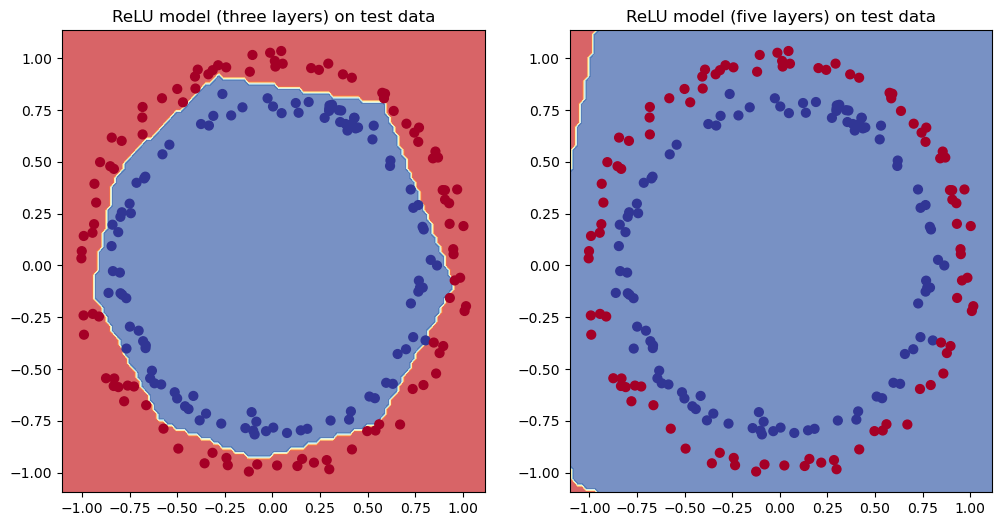

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("ReLU model (three layers) on test data")
plot_decision_boundary(model_relu_3l, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("ReLU model (five layers) on test data")
plot_decision_boundary(model_relu_5l, X_test, y_test)

Interesting. I would have assumed that adding more hidden layers would results in the network learning more complex patterns, instead it results simply in a nonsensical performance decay.

### 2.4 Potential reasons for performance decay
I asked chatGPT for potential reasons for the performance decay:

1. **Model architecture**:
The model has a uniform architecture where each hidden layer has 5 neurons. This can lead to redundant computations and insufficient learning capacity because the model might not be learning meaningful hierarchical representations.
2. **Gradient Flow and Vanishing/Exploding Gradients**: In deeper networks, the gradients can vanish or explode during backpropagation, making it difficult for the network to learn effectively. The uniform architecture of the model might have exacerbated this issue.
3. **Capacity and Overfitting**: The model might have too much capacity (due to the repeated layers with the same size), leading to overfitting on the noise in the data rather than learning the underlying patterns.

## 3 Alternating hidden layer size in deep neural networks
Let's try improve the model by tweaking the architecture. We could try to alternate the size of the hidden layers so that the model learns to encode and then reconstruct the underlying structure of the input data.

In [37]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_relu_5l_alt = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 3),
    nn.ReLU(),
    nn.Linear(3, 5),
    nn.ReLU(),
    nn.Linear(5, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
).to(device)

optim_relu_5l_alt = torch.optim.SGD(params=model_relu_5l_alt.parameters(), lr=0.1)

In [38]:
fit(epochs=600,
    model=model_relu_5l_alt,
    loss_fn=loss_fn,
    opt=optim_relu_5l_alt,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.70625, accuracy 50.00
Epoch 10: test loss 0.69317, accuracy 50.00
Epoch 20: test loss 0.69316, accuracy 50.00
Epoch 30: test loss 0.69316, accuracy 50.00
Epoch 40: test loss 0.69316, accuracy 50.00
Epoch 50: test loss 0.69315, accuracy 50.00
Epoch 60: test loss 0.69315, accuracy 50.00
Epoch 70: test loss 0.69315, accuracy 50.00
Epoch 80: test loss 0.69314, accuracy 50.00
Epoch 90: test loss 0.69314, accuracy 50.00
Epoch 100: test loss 0.69313, accuracy 50.00
Epoch 110: test loss 0.69312, accuracy 50.00
Epoch 120: test loss 0.69312, accuracy 50.00
Epoch 130: test loss 0.69312, accuracy 50.00
Epoch 140: test loss 0.69311, accuracy 50.00
Epoch 150: test loss 0.69311, accuracy 50.00
Epoch 160: test loss 0.69310, accuracy 50.00
Epoch 170: test loss 0.69310, accuracy 50.00
Epoch 180: test loss 0.69309, accuracy 50.00
Epoch 190: test loss 0.69308, accuracy 50.00
Epoch 200: test loss 0.69307, accuracy 50.00
Epoch 210: test loss 0.69306, accuracy 50.00
Epoch 220: test loss 

We see that it takes comparitively more time for the five layer neural network to converge, but with the hidden layers alternating in size, encoding and decoding the data, it seems to be able to perfectly learn the underlying structure of the data.

### 3.1 Why does alternating hidden layer size increase performance?
Here are some suggestions by chatGPT for the improved performance of the model:

1. **Feature Abstraction**:
This structure encourages the network to learn more abstract and hierarchical representations by progressively compressing and expanding the feature space, which can help in capturing complex patterns in the data.

2. **Gradient Flow**: Alternating layer sizes help in stabilizing the gradient flow during backpropagation, reducing the likelihood of vanishing or exploding gradients, and leading to more effective weight updates.

3. **Overfitting**:
Provides a more balanced architecture that can help prevent overfitting by encouraging the network to focus on learning essential features rather than memorizing the training data.

4. **Inductive bias**: Offers a better inductive bias for capturing the underlying structure of the data, especially for problems requiring complex decision boundaries.

However, in the end the decision boundary that the five layer neural network learns does not look so different from the one that the three layer neural network learns.

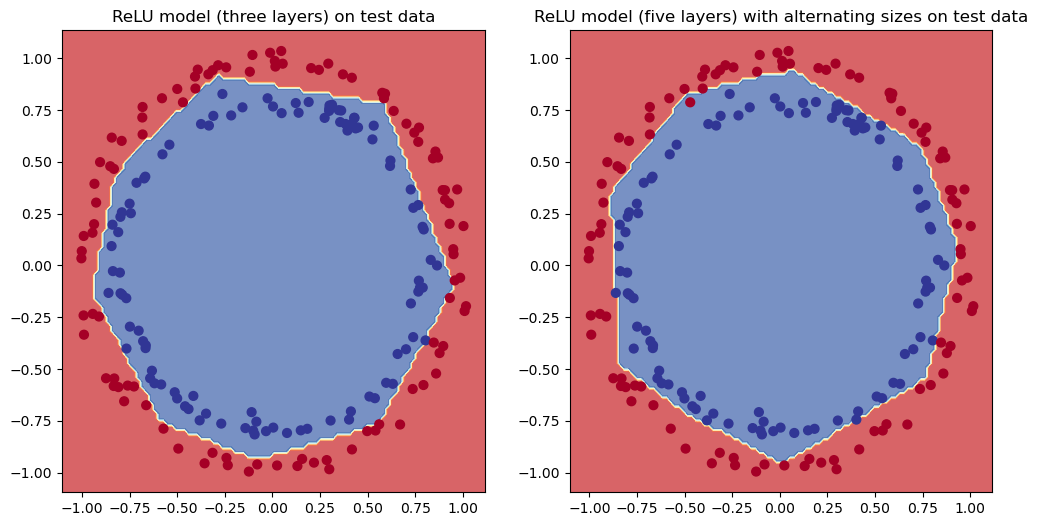

In [39]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("ReLU model (three layers) on test data")
plot_decision_boundary(model_relu_3l, X_test, y_test)
plt.subplot(1, 2, 2)
plt.title("ReLU model (five layers) with alternating sizes on test data")
plot_decision_boundary(model_relu_5l_alt, X_test, y_test)

## 4. Investigating performance decay in arbitrarily deep unifrom neural network

Eventhough we have found a working architecture, it would still be intereseting to exlpore, why the unifrom five layer model couldn't come up with a decision boundary. We are scientists now.

Let's see if we can validate chatGPT's suggestions and identify the underlying issue with the uniform five layer architecture.

### 4.1 Testing for vanishing gradients
The first thing we can test is whether the gradients in the unifrom 5l nn vanish or explode. To do so, we only need to add some code to the fitting function, so that it also outputs the gradients of, say, the firsrt layer.

In [42]:
def fit_output_grad(epochs, model, loss_fn, opt, train_dl, test_dl, acc_fn):
  for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
      batch_loss(model, loss_fn, acc_fn, xb, yb, opt)
    
    if epoch % 100 == 0:

      model.eval()
      with torch.inference_mode():
        batch_losses, batch_acc, batch_sizes = zip(
            *[batch_loss(model, loss_fn, acc_fn, xb, yb) for xb, yb in test_dl]
        )
        test_loss = np.sum((np.multiply(batch_losses, batch_sizes))) / np.sum(batch_sizes)
        test_acc = np.sum((np.multiply(batch_acc, batch_sizes))) / np.sum(batch_sizes)
      
      print(f"""Epoch {epoch}| Loss: {test_loss:.3f}, Accuracy: {test_acc:.2f}
            
1st layer gradients: 
{model[0].weight.grad.mT.squeeze().detach().numpy()}
            
2nd layer gradients: 
{model[2].weight.grad.mT.squeeze().detach().numpy()}
            
3rd layer gradients: 
{model[4].weight.grad.mT.squeeze().detach().numpy()}
            
4th layer gradients: 
{model[6].weight.grad.mT.squeeze().detach().numpy()}
            
5th layer gradients: 
{model[8].weight.grad.mT.squeeze().detach().numpy()}
      
      """)

In [43]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_relu_5l = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
).to(device)

optim_relu_5l = torch.optim.SGD(params=model_relu_5l.parameters(), lr=0.1)

In [44]:
np.set_printoptions(precision=3)

fit_output_grad(epochs=500,
    model=model_relu_5l,
    loss_fn=loss_fn,
    opt=optim_relu_5l,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0| Accuracy: 50.00
            
1st layer gradients: 
[[ 1.542e-04  3.717e-04  5.813e-05 -1.439e-04 -3.409e-04]
 [-6.588e-04 -1.348e-04 -4.804e-04  1.216e-04  3.815e-04]]
            
2nd layer gradients: 
[[-7.667e-04  0.000e+00  0.000e+00  1.072e-04 -2.547e-04]
 [-3.387e-04  0.000e+00  4.220e-05  3.533e-05 -1.984e-04]
 [ 4.735e-04  0.000e+00  1.725e-04 -5.759e-05  2.189e-04]
 [-3.518e-04  0.000e+00  9.039e-05  3.670e-05 -2.061e-04]
 [-2.139e-03  0.000e+00  0.000e+00  4.770e-04  5.576e-04]]
            
3rd layer gradients: 
[[-1.806e-04  4.704e-04 -1.934e-04  0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 [ 2.719e-05 -1.678e-06 -1.242e-05  0.000e+00  0.000e+00]
 [-1.453e-03  1.857e-04  6.060e-04  0.000e+00  0.000e+00]
 [-8.163e-04 -2.394e-05  4.175e-04  0.000e+00  0.000e+00]]
            
4th layer gradients: 
[[0.    0.002 0.    0.    0.003]
 [0.    0.003 0.    0.    0.002]
 [0.    0.003 0.    0.    0.004]
 [0.    0.    0.    0.    0.   ]
 [0.

From our little experiment we have found out that we are dealing with **vanishing gradients**. But why do they vanish, and how can we mitigate the problem? Let's ask chatGPT to give us some ideas to further look into.


## 5 Excursus: Vanishing gradients - causes and solutions

### 5.1 Potential Reasons for Vanishing Gradients and Performance Degradation
The following list was created by chatGPT.

#### 1. Vanishing Gradients
- **Explanation:** In deep networks, especially those with many layers, the gradients can become very small as they propagate back through the network during backpropagation. This issue is exacerbated by the use of certain activation functions like sigmoid or tanh, though ReLU can also experience this under certain conditions.
- **Impact:** When gradients vanish, the network weights stop updating effectively, causing the network to stop learning and performance to stagnate or deteriorate.

#### 2. Poor Initialization
- **Explanation:** If the weights of the network are not initialized properly, it can lead to poor gradient flow. For instance, if weights are initialized with values that are too small, it can cause the gradients to vanish.
- **Impact:** Poor initialization can lead to the network struggling to escape regions of the loss landscape with very small gradients, hindering learning.

#### 3. Learning Rate Issues
- **Explanation:** An inappropriate learning rate can cause learning dynamics issues. If the learning rate is too high, the model may initially learn patterns but then start diverging, leading to unstable training. Conversely, if the learning rate is too low, the model may fail to learn effectively.
- **Impact:** An initially effective learning rate might cause the model to sporadically achieve good performance, but as training continues, the model might get stuck or diverge.

#### 4. Network Capacity and Architecture
- **Explanation:** The uniform network architecture with the same number of neurons in each layer might not provide the necessary capacity to capture complex patterns. This could lead to initial learning followed by overfitting or the network settling into poor local minima.
- **Impact:** The network might initially find some useful patterns but then fail to generalize, leading to performance degradation.

#### 5. Overfitting and Underfitting
- **Explanation:** Overfitting occurs when the model learns noise or irrelevant details from the training data, which can lead to poor generalization to test data. Underfitting occurs when the model is too simple to capture the underlying patterns in the data.
- **Impact:** The model might initially perform well on the training data but fail to maintain performance on unseen data, leading to an accuracy drop to 50% (random guessing).


### 5.2 Possible Solutions
The following list was created by chatGPT.

#### 1. Better Weight Initialization
Use initialization methods like Xavier (Glorot) or He initialization to ensure better gradient flow.
```python
nn.init.xavier_uniform_(layer.weight)
```

#### 2. Adjust Learning Rate
Experiment with different learning rates or use learning rate schedules to adapt the learning rate during training.
```python
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
```

#### 3. Activation Functions
Ensure the use of appropriate activation functions like ReLU, and consider using variants like Leaky ReLU or ELU to mitigate vanishing gradients.
```python
nn.LeakyReLU()
```

#### 4. Batch Normalization
Incorporate batch normalization to stabilize the learning process and improve gradient flow.
```python
nn.Sequential(
    nn.Linear(2, 5),
    nn.BatchNorm1d(5),
    nn.ReLU(),
    ...
)
```

#### 5. Regularization
Apply dropout or weight decay to reduce overfitting and improve generalization.
```python
nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Dropout(0.5),
    ...
)
```

#### 6. Gradient Clipping
Use gradient clipping to prevent exploding gradients, which can also help stabilize training.
```python
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
```

By addressing these potential issues, you can improve the stability and performance of your neural network, preventing the vanishing gradient problem and ensuring sustained learning throughout the training process.

## 6. Modulating the learning rate
Let's try to fix the vanishing gradients by decreasing the leaning rate of the five-layer uniform neural network.

In [45]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_relu_5l = nn.Sequential(
    nn.Linear(2, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 5),
    nn.ReLU(),
    nn.Linear(5, 1)
).to(device)

# use lr=0.01 instead of lr=0.1
optim_relu_5l = torch.optim.SGD(params=model_relu_5l.parameters(), lr=0.01)

In [46]:
fit(epochs=1000,
    model=model_relu_5l,
    loss_fn=loss_fn,
    opt=optim_relu_5l,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.71220, accuracy 50.00
Epoch 10: test loss 0.69639, accuracy 50.00
Epoch 20: test loss 0.69338, accuracy 50.00
Epoch 30: test loss 0.69282, accuracy 50.00
Epoch 40: test loss 0.69273, accuracy 50.00
Epoch 50: test loss 0.69273, accuracy 50.50
Epoch 60: test loss 0.69272, accuracy 55.50
Epoch 70: test loss 0.69272, accuracy 51.50
Epoch 80: test loss 0.69275, accuracy 50.00
Epoch 90: test loss 0.69277, accuracy 50.00
Epoch 100: test loss 0.69276, accuracy 49.50
Epoch 110: test loss 0.69275, accuracy 49.00
Epoch 120: test loss 0.69273, accuracy 48.50
Epoch 130: test loss 0.69272, accuracy 48.50
Epoch 140: test loss 0.69270, accuracy 48.50
Epoch 150: test loss 0.69268, accuracy 48.50
Epoch 160: test loss 0.69266, accuracy 48.50
Epoch 170: test loss 0.69264, accuracy 48.50
Epoch 180: test loss 0.69262, accuracy 48.50
Epoch 190: test loss 0.69259, accuracy 48.00
Epoch 200: test loss 0.69256, accuracy 48.00
Epoch 210: test loss 0.69253, accuracy 48.00
Epoch 220: test loss 

Yay! It seems that we have found a solution to the issue. Apparently, a learning rate of 0.1 was to high for the five layer uniform neural network. Reducing the learning rate to 0.01 helped achieve an accuracy of 99% (previously unseen).

Let's see if the accuracy holds up if we train the network for another 100 epochs or whether it decays again. As we have seen with the sporadic performance improvements when using lr=0.1. 

My bet is that we have reached a local minimum by using a smaller step size. In contrast, using a lr=0.1 the model overshot any local minima and landed on a shoulder in the optimization landscape.

In [47]:
fit(epochs=100,
    model=model_relu_5l,
    loss_fn=loss_fn,
    opt=optim_relu_5l,
    train_dl=train_dl,
    test_dl=test_dl,
    acc_fn=accuracy_fn)

Epoch 0: test loss 0.06001, accuracy 99.00
Epoch 10: test loss 0.05873, accuracy 99.00
Epoch 20: test loss 0.05733, accuracy 99.00
Epoch 30: test loss 0.05612, accuracy 99.00
Epoch 40: test loss 0.05493, accuracy 99.00
Epoch 50: test loss 0.05392, accuracy 99.00
Epoch 60: test loss 0.05301, accuracy 99.00
Epoch 70: test loss 0.05243, accuracy 99.00
Epoch 80: test loss 0.05172, accuracy 99.00
Epoch 90: test loss 0.05087, accuracy 99.00


The model has indeed converged. Let's visualize the decision boundary the model has found!

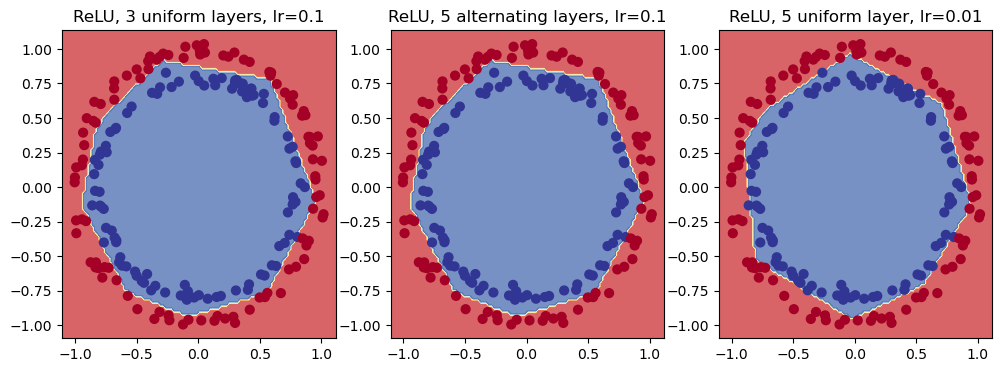

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("ReLU, 3 uniform layers, lr=0.1")
plot_decision_boundary(model_relu_3l, X_test, y_test)
plt.subplot(1, 3, 2)
plt.title("ReLU, 5 alternating layers, lr=0.1")
plot_decision_boundary(model_relu_3l, X_test, y_test)
plt.subplot(1, 3, 3)
plt.title("ReLU, 5 uniform layer, lr=0.01")
plot_decision_boundary(model_relu_5l, X_test, y_test)

## 7. Conclusion
Our little experiment with increasing the depth of the neural network showed, that complex models do not necessarily do better. All the models learned some form of octagon which fitted the data well enough, but no model actually learned to represent the decision boundary as a clean circle (ground truth).

In ou case, the use of ReLU inevitably leads to a jagged decision boundary. A smoother activation function like the sigmoid may have resulted in a 
rounder decision boundary resembling the true distribution (circle) more closely. However, ReLU is still able to classify the test data with 99% 
accuracy and has performance advantages over sigmoid.

Although this is a simple toy dataset, our experimentation illustrates that creating an accurate model of reality involves more than adding more layers. It takes a deep understanding of the underlying problem and theoretical knowledge of machine learning.